In [1]:
from sympy import Symbol, Function, diff, Matrix, zeros, symbols, N, sqrt, Pow, Mul, Add, log, exp, sin, cos, tan, lambdify
import sympy
import numpy as np
import matplotlib.pyplot as plt
import expr_optimiser

## Define system

In [2]:
dim = 2

In [3]:
t = Symbol('t')
T = Symbol('T', nonnegative=True)
g = Symbol('gamma')
b = Symbol('beta')

coords = symbols('x y')
dcoords = symbols('xdot ydot')

x, y = coords
xdot, ydot = dcoords

r = Function('r')(x,y)
coord_functions = {
    r : sqrt(x**2 + y**2)
}

In [4]:
coord_func_derivative_rules = {
    diff(r,x) : x/r,
    diff(r,y) : y/r
}

In [5]:
params = symbols('U0 xip xim Ux0 dUx')
r0 = Symbol('r0')
U0, xip, xim, Ux0, dUx = params

In [6]:
#r = sqrt(x**2 + y**2)
k = (3*U0 / r0**2) * (2 + xip + xim*y/r)

U_switch = (1 / (2*r0**4))*(r - r0)**2 * (k*r**2*r0**2 - 2*U0*(r-r0)*(3*r + r0))
U_switch = U_switch.subs(r0, 1)

Ux_quartic = ( Ux0 * (x-1)**2 - dUx * (x-2) / 4 ) * (x+1)**2

U = U_switch + Ux_quartic

In [7]:
def cdiff(expr, coord):
    dexpr = diff(expr, coord)
    
    for df, df_expr in coord_func_derivative_rules.items():
        dexpr = dexpr.subs(df, df_expr)
        
    return dexpr

In [8]:
F = zeros(dim, 1)
for i in range(dim):
    F[i] = -cdiff(U, coords[i])
    F[i] = F[i].simplify()
    
div_F = 0
for i in range(dim):
    div_F += cdiff(F[i], coords[i])
div_F = div_F.simplify()
    
L_OM = (1/(2*g)) * div_F
L_FW = 0
for i in range(dim):
    L_OM += (b*g/4) * (dcoords[i] - F[i]/g)**2
    L_FW += (b*g/4) * (dcoords[i] - F[i]/g)**2
L_OM = L_OM.simplify()
L_FW = L_FW.simplify()

In [9]:
def compute_gradL(L):
    L_x = zeros(dim, 1)
    L_xd = zeros(dim, 1)
    for i in range(dim):
        cdiff(L, coords[i])
        L_x[i] = cdiff(L, coords[i]).simplify()
        L_xd[i] = cdiff(L, dcoords[i]).simplify()
    return L_x, L_xd
def compute_hessL(L):
    L_x_x = zeros(dim, dim)
    L_xd_x = zeros(dim, dim)
    L_xd_xd = zeros(dim, dim)
    for i in range(dim):
        for j in range(dim):
            L_x_x[i,j] = cdiff(cdiff(L, coords[i]), coords[j]).simplify()
            L_xd_x[i,j] = cdiff(cdiff(L, dcoords[i]), coords[j]).simplify()
            L_xd_xd[i,j] = cdiff(cdiff(L, dcoords[i]), dcoords[j]).simplify()
    return L_x_x, L_xd_x, L_xd_xd

In [10]:
L_x_OM, L_xd_OM = compute_gradL(L_OM)
L_x_FW, L_xd_FW = compute_gradL(L_FW)

In [11]:
L_x_x_OM, L_xd_x_OM, L_xd_xd_OM = compute_hessL(L_OM)
L_x_x_FW, L_xd_x_FW, L_xd_xd_FW = compute_hessL(L_FW)

## Plots and Analysis

In [12]:
plot_params = {
    U0 : 3,
    xim : 2,
    xip : 2,
    Ux0 : 2,
    dUx : 0,
}

U_plot = U.subs(r, sqrt(x**2 + y**2))

for k, v in plot_params.items():
    U_plot = U_plot.subs(k, v)

U_plot_func = lambdify([x,y], U_plot)

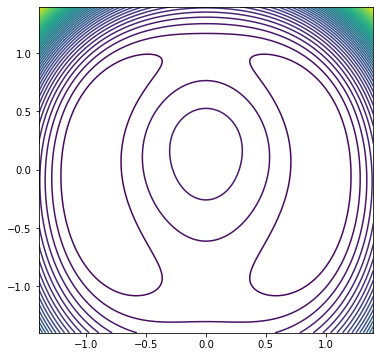

In [13]:
xs = np.linspace(-1.4, 1.4, 400)
ys = np.linspace(-1.4, 1.4, 400)
X, Y = np.meshgrid(xs,  ys)
Z = U_plot_func(X, Y)

fig, ax = plt.subplots(figsize=(6,6))

ax.contour(X, Y, Z, levels=50)

## Generate code

Pre-process the symbolic expressions

In [14]:
U = N(U)
F = N(F)
div_F = N(div_F)
L_OM = N(L_OM)
L_FW = N(L_FW)

L_x_OM = N(L_x_OM)
L_xd_OM = N(L_xd_OM)

L_x_FW = N(L_x_FW)
L_xd_FW = N(L_xd_FW)

L_x_x_OM = N(L_x_x_OM)
L_xd_x_OM = N(L_xd_x_OM)
L_xd_xd_OM = N(L_xd_xd_OM)

L_x_x_FW = N(L_x_x_FW)
L_xd_x_FW = N(L_xd_x_FW)
L_xd_xd_FW = N(L_xd_xd_FW)

In [15]:
substitution_rules = {
    sqrt(x**2 + y**2) : r,
    x**2 + y**2 : r**2
}

def apply_substs(expr):
    for a, b in substitution_rules.items():
        expr = expr.subs(a,b)
    return expr

U = apply_substs(U)
F = apply_substs(F)
div_F = apply_substs(div_F)
L_OM = apply_substs(L_OM)
L_FW = apply_substs(L_FW)

L_x_OM = apply_substs(L_x_OM)
L_xd_OM = apply_substs(L_xd_OM)

L_x_FW = apply_substs(L_x_FW)
L_xd_FW = apply_substs(L_xd_FW)

L_x_x_OM = apply_substs(L_x_x_OM)
L_xd_x_OM = apply_substs(L_xd_x_OM)
L_xd_xd_OM = apply_substs(L_xd_xd_OM)

L_x_x_FW = apply_substs(L_x_x_FW)
L_xd_x_FW = apply_substs(L_xd_x_FW)
L_xd_xd_FW = apply_substs(L_xd_xd_FW)

In [16]:
for i in range(len(coords)):
    coords[i].name = 'x[%s,i]' % i

for i in range(len(dcoords)):
    dcoords[i].name = 'xd[%s,i]' % i

In [17]:
# Add the coord functions to the coords
coords_and_coord_functions = list(coords) + list(coord_functions.keys())

In [18]:
str_substitutions = {
}

In [19]:
expr_optimiser.set_coords(coords_and_coord_functions, dcoords)

In [20]:
def to_ccode(sym):
    # Replace coordinate functions with symbols
    for cf in coord_functions:
        sym = sym.subs(cf, Symbol(cf.name))
    
    code = sympy.printing.ccode(sym)
    
    for k in str_substitutions:
        code = code.replace(k, str_substitutions[k])
        
    return code

In [21]:
def function_formatter(function_name, lines):
    code_lines =  [function_name]
    tab = '    '
    
    for tabs, code_line in lines:
        code_lines.append( tabs*tab + code_line )
        
    return '\n'.join(code_lines).strip()

In [22]:
coord_func_ccode_declarations = []
for cf, cf_expr in coord_functions.items():
    decl = '%s = %s' % (cf.name, to_ccode(cf_expr))
    coord_func_ccode_declarations.append(decl)

In [23]:
def get_params_cdef(exprs, params, include_beta_gamma=True):
    cdef_params = []
    cdef_params.append((1, 'cdef:'))
    cdef_params.append((2, 'int i'))
    cdef_params.append((2, 'int dim = x.shape[0]'))
    cdef_params.append((2, 'int Nt = x.shape[1]'))
    
    if include_beta_gamma:
        cdef_params.append((2, 'DTYPE_t beta = self.beta'))
        cdef_params.append((2, 'DTYPE_t gamma = self.gamma'))
    for p in params:
        cdef_params.append( (2, 'DTYPE_t %s = self.%s' % (p, p)) )
    for cf, cf_expr in coord_functions.items():
        cdef_params.append( (2, 'DTYPE_t %s' % cf.name) )
    for var in expr_optimiser.get_used_vars(exprs):
        const_expr = expr_optimiser.const_lookup[var][1]
        cdef_params.append( (2, 'DTYPE_t %s = %s' % (var, expr_optimiser.dereference_expr(const_expr) ) ) )
        
    return cdef_params

In [24]:
U = expr_optimiser.sym_formatter(U)
F = expr_optimiser.sym_formatter(F)
div_F = expr_optimiser.sym_formatter(div_F)
L_OM = expr_optimiser.sym_formatter(L_OM)
L_FW = expr_optimiser.sym_formatter(L_FW)

print(1)
L_x_OM = expr_optimiser.sym_formatter(L_x_OM)
L_xd_OM = expr_optimiser.sym_formatter(L_xd_OM)

print(2)
L_x_FW = expr_optimiser.sym_formatter(L_x_FW)
L_xd_FW = expr_optimiser.sym_formatter(L_xd_FW)

print(3)
L_x_x_OM = expr_optimiser.sym_formatter(L_x_x_OM)
L_xd_x_OM = expr_optimiser.sym_formatter(L_xd_x_OM)
L_xd_xd_OM = expr_optimiser.sym_formatter(L_xd_xd_OM)

print(4)
L_x_x_FW = expr_optimiser.sym_formatter(L_x_x_FW)
L_xd_x_FW = expr_optimiser.sym_formatter(L_xd_x_FW)
L_xd_xd_FW = expr_optimiser.sym_formatter(L_xd_xd_FW)

1
2
3
4


### Potential

In [25]:
code_potential = [] + coord_func_ccode_declarations
code_potential.append('potential[i] = %s' % to_ccode(U))
cdef_potential = get_params_cdef(U, params, include_beta_gamma=False)

### Force and div Force

In [26]:
code_force = []
code_div_force = None

code_force += coord_func_ccode_declarations

for j in range(dim):
    code_line = 'force[%s,i] = %s' % (j, to_ccode(F[j]))
    code_force.append(code_line)

code_div_force = 'div_force[i] = %s' % to_ccode(div_F)

In [27]:
cdef_force = get_params_cdef(F, params, include_beta_gamma=False)
cdef_force_and_div_force = get_params_cdef([F, div_F], params, include_beta_gamma=False)

### Gradient of Lagrangian

In [28]:
def get_gradL_code(L_x, L_xd):
    code_L_x = [] + coord_func_ccode_declarations
    code_L_xd = [] 

    for j in range(dim):
        code_line = 'L_x[%s,i] = %s' % (j, to_ccode(L_x[j]))
        code_L_x.append(code_line)
        
        code_line = 'L_xd[%s,i] = %s' % (j, to_ccode(L_xd[j]))
        code_L_xd.append(code_line)
            
    return code_L_x, code_L_xd
            
code_L_x_OM, code_L_xd_OM = get_gradL_code(L_x_OM, L_xd_OM)
code_L_x_FW, code_L_xd_FW = get_gradL_code(L_x_FW, L_xd_FW)

In [29]:
cdef_gradL_OM = get_params_cdef([L_x_OM, L_xd_OM], params, include_beta_gamma=True)
cdef_gradL_FW = get_params_cdef([L_x_FW, L_xd_FW], params, include_beta_gamma=True)

### Hessian of Lagrangian

In [30]:
def get_hessL_code(L_x_x, L_xd_x, L_xd_xd):
    code_L_x_x = [] + coord_func_ccode_declarations
    code_L_xd_x = [] 
    code_L_xd_xd = []

    for j in range(dim):
        for k in range(dim):
            code_line = 'L_x_x[%s,%s,i] = %s' % (j, k, to_ccode(L_x_x[j,k]))
            code_L_x_x.append(code_line)
            
            code_line = 'L_xd_x[%s,%s,i] = %s' % (j, k, to_ccode(L_xd_x[j,k]))
            code_L_xd_x.append(code_line)
            
            code_line = 'L_xd_xd[%s,%s,i] = %s' % (j, k, to_ccode(L_xd_xd[j,k]))
            code_L_xd_xd.append(code_line)
            
    return code_L_x_x, code_L_xd_x, code_L_xd_xd
            
code_L_x_x_OM, code_L_xd_x_OM, code_L_xd_xd_OM = get_hessL_code(L_x_x_OM, L_xd_x_OM, L_xd_xd_OM)
code_L_x_x_FW, code_L_xd_x_FW, code_L_xd_xd_FW = get_hessL_code(L_x_x_FW, L_xd_x_FW, L_xd_xd_FW)

In [31]:
cdef_hessL_OM = get_params_cdef([L_x_x_OM, L_xd_x_OM, L_xd_xd_OM], params, include_beta_gamma=True)
cdef_hessL_FW = get_params_cdef([L_x_x_FW, L_xd_x_FW, L_xd_xd_FW], params, include_beta_gamma=True)

### Cython functions

In [32]:
function_name = 'cdef DTYPE_t _compute_potential(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:] potential):'

lines = []
lines += cdef_potential
lines += [(1, '')]
lines += [(1, 'for i in range(Nt):')]
lines += [(2, l) for l in code_potential]

_compute_potential = function_formatter(function_name, lines)

In [33]:
function_name = 'cdef DTYPE_t _compute_force(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:,:] force):'

lines = []
lines += cdef_force
lines += [(1, '')]
lines += [(1, 'for i in range(Nt):')]
lines += [(2, l) for l in code_force]

_compute_force = function_formatter(function_name, lines)

In [34]:
function_name = 'cdef DTYPE_t _compute_force_and_div_force(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:,:] force, DTYPE_t[:] div_force):'

lines = []
lines += cdef_force_and_div_force
lines += [(1, '')]
lines += [(1, 'for i in range(Nt):')]
lines += [(2, l) for l in code_force]
lines += [(2, code_div_force)]

_compute_force_and_div_force = function_formatter(function_name, lines)

In [35]:
def get_gradL_function(code_L_x, code_L_xd, cdef_params, func_postfix):
    function_name = 'cdef DTYPE_t _compute_gradL_%s(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:,:] xd, DTYPE_t[:,:] L_x, DTYPE_t[:,:] L_xd):' % func_postfix

    lines = []
    lines += cdef_params
    lines += [(1, '')]
    lines += [(1, 'for i in range(Nt):')]
    lines += [(2, l) for l in code_L_x]
    lines += [(2, l) for l in code_L_xd]
    
    return function_formatter(function_name, lines)

_compute_gradL_OM = get_gradL_function(code_L_x_OM, code_L_xd_OM, cdef_gradL_OM, 'OM')
_compute_gradL_FW = get_gradL_function(code_L_x_FW, code_L_xd_FW, cdef_gradL_FW, 'FW')

In [36]:
def get_hessL_function(code_L_x_x, code_L_xd_x, code_L_xd_xd, cdef_params, func_postfix):
    function_name = 'cdef DTYPE_t _compute_hessL_%s(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:,:] xd, DTYPE_t[:,:,:] L_x_x, DTYPE_t[:,:,:] L_xd_x, DTYPE_t[:,:,:] L_xd_xd):' % func_postfix

    lines = []
    lines += cdef_params
    lines += [(1, '')]
    lines += [(1, 'for i in range(Nt):')]
    lines += [(2, l) for l in code_L_x_x]
    lines += [(2, l) for l in code_L_xd_x]
    lines += [(2, l) for l in code_L_xd_xd]
    
    return function_formatter(function_name, lines)

_compute_hessL_OM = get_hessL_function(code_L_x_x_OM, code_L_xd_x_OM, code_L_xd_xd_OM, cdef_hessL_OM, 'OM')
_compute_hessL_FW = get_hessL_function(code_L_x_x_FW, code_L_xd_x_FW, code_L_xd_xd_FW, cdef_hessL_FW, 'FW')

In [37]:
print('\n\n'.join([
    _compute_potential,
    _compute_force,
    _compute_force_and_div_force,
    _compute_gradL_OM,
    _compute_gradL_FW,
    _compute_hessL_OM,
    _compute_hessL_FW
]))

cdef DTYPE_t _compute_potential(self, DTYPE_t[:] ts, DTYPE_t[:,:] x, DTYPE_t[:] potential):
    cdef:
        int i
        int dim = x.shape[0]
        int Nt = x.shape[1]
        DTYPE_t U0 = self.U0
        DTYPE_t xip = self.xip
        DTYPE_t xim = self.xim
        DTYPE_t Ux0 = self.Ux0
        DTYPE_t dUx = self.dUx
        DTYPE_t r
        DTYPE_t var_1p5_tim_U0_tim_xip = 1.5*U0*xip
        DTYPE_t var_2p0_tim_U0 = 2.0*U0
        DTYPE_t var_3p0_tim_U0_tim_xim = 3.0*U0*xim
        DTYPE_t var_2p0_tim_Ux0 = 2.0*Ux0
        DTYPE_t var_var_0p5_tim_dUx_pls_var_1p0_tim_U0_pls_var_1p0_tim_Ux0 = 1.0*U0 + 1.0*Ux0 + 0.5*dUx
        DTYPE_t var_0p25_tim_dUx = 0.25*dUx
        DTYPE_t var_3p0_tim_U0_tim_xip = 3.0*U0*xip
        DTYPE_t var_1p5_tim_U0_tim_xim = 1.5*U0*xim
        DTYPE_t var_0p75_tim_dUx = 0.75*dUx
        DTYPE_t var_3p0_tim_U0 = 3.0*U0
    
    for i in range(Nt):
        r = sqrt(pow(x[0,i], 2) + pow(x[1,i], 2))
        potential[i] = Ux0*pow(x[0,i], 4) + pow(r, 4)*v